In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

In [2]:
from sqlalchemy import create_engine

# MySQL 데이터베이스 연결 정보
user = 'root'
password = '1234'
host = 'localhost'
database = 'trouver'

# SQLAlchemy 엔진 생성
engine = create_engine(f'mysql+mysqlconnector://{user}:{password}@{host}/{database}')

In [3]:
import tensorflow as tf
from tensorflow import keras
path = './dataset'

# Dataset
* rating.csv
* travel.csv
* users : 자체 DB 사용 예정 (MySQL)
> 출처 : BC카드 제주 관광객 소비패턴 변화 분석, 
> visitJEJU 기반 데이터 수집

In [4]:
os.listdir(path)

['rating.csv', 'travel.csv', 'users.dat', 'visitjeju_data.xlsx']

In [5]:
#여행지 데이터프레임
def load_travels():
    col_name = ['contentsid','regioncd_value','title','tag']
    travel_df = pd.read_csv(path+"/travel.csv",sep=';', header=0, engine='python', usecols=col_name)
    # travel_df.head()
    return travel_df
# load_travels()

In [6]:
#유저 평가 데이터프레임
def load_ratings() :
    col_name = ['user_id','regioncd_value','pla_r_rate','pla_r_date']
    rating_df = pd.read_csv(path+"/rating.csv",sep=';', header=0, engine='python', names=col_name)
    # rating_df.head()
    return rating_df
# load_ratings()

임의로 사용자의 나이대에 따라 age_id 부여, 지역에 따라 id 부여.  
[참고 Notion Link 🔗](https://www.notion.so/jxxngxnt/44e0fcdeb8814a0ea9e12de162137637?pvs=4#cafa46a992c94de2a44dd8b375933ac6)  

In [7]:
# 서비스에 이용할 유저 데이터
def load_users() :

    #유저 데이터프레임
    query = '''
    SELECT 
        BIN_TO_UUID(user_id) as user_id,user_mbti, 
        user_gender,
        @age := FLOOR(DATEDIFF(NOW(), user_birth) / 365.25) AS age,
        CASE
            WHEN @age <=19 THEN 00
            WHEN @age BETWEEN 20 AND 29 THEN 20
            WHEN @age BETWEEN 30 AND 39 THEN 30
            WHEN @age BETWEEN 40 AND 49 THEN 40
            WHEN @age BETWEEN 50 AND 59 THEN 50
            WHEN @age >=60 THEN '60+'
        END AS user_age_group
    FROM user'''  # 실행할 SQL 쿼리

    users_df = pd.read_sql(query, engine)
    # print(users_df.head())
    return users_df

# 서비스에 이용하기 전 테스트용 유저 데이터
def load_users_test() :
    COL_NAME = ['userId','gender','age','Occupation','zip_code']
    df = pd.read_csv(os.path.join(path,"users.dat"),sep='::', header=None, engine='python', names=COL_NAME)
    # df.head()
    return df

# load_users_test()

## preprocess datasets
### data 1. Ratings_df

In [8]:
ratings_df = load_ratings()
ratings_df.head()

,user_id,regioncd_value,pla_r_rate,pla_r_date
0,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,4,5.8,1차년도
1,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,4,7.4,2차년도
2,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,2,6.6,1차년도
3,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,2,8.5,2차년도
4,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,1,7.6,1차년도


In [9]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         80 non-null     object 
 1   regioncd_value  80 non-null     int64  
 2   pla_r_rate      80 non-null     float64
 3   pla_r_date      80 non-null     object 
dtypes: float64(1), int64(1), object(2)
memory usage: 2.6+ KB


In [10]:
ratings_df.drop("pla_r_date", axis=1, inplace=True)

In [11]:
ratings_df.head()

,user_id,regioncd_value,pla_r_rate
0,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,4,5.8
1,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,4,7.4
2,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,2,6.6
3,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,2,8.5
4,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,1,7.6


<Axes: ylabel='Frequency'>

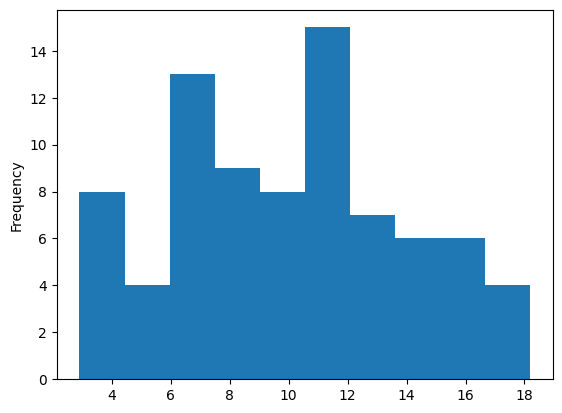

In [12]:
ratings_df.pla_r_rate.plot.hist()

### data 2. travels_df

In [13]:
travels_df = load_travels()
travels_df.head()

,contentsid,title,regioncd_value,tag
0,CNTS_200000000015109,숲을걷다,1,"애월,소품샵,감귤모자,의류,엽서,잡화"
1,CNTS_000000000021301,아코하루,1,"쇼핑,공방,기념품,공용주차장,현금결제,카드결제,무료WIFI,편의점"
2,CNTS_200000000007257,풍년상회,1,"쇼핑,기념품"
3,CNTS_200000000013168,세계자동차&피아노박물관 4th 봄날의 향연 뮤지엄콘서트,4,"축제,문화관광"
4,CNTS_000000000017497,이중섭미술관,4,NaN


In [14]:
travels_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5362 entries, 0 to 5361
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   contentsid      5362 non-null   object
 1   title           5362 non-null   object
 2   regioncd_value  5362 non-null   int64 
 3   tag             5356 non-null   object
dtypes: int64(1), object(3)
memory usage: 167.7+ KB


##### Fill Nan : 0

In [15]:
travels_df["tag"] = travels_df["tag"].fillna("없음")
travels_df.head()

,contentsid,title,regioncd_value,tag
0,CNTS_200000000015109,숲을걷다,1,"애월,소품샵,감귤모자,의류,엽서,잡화"
1,CNTS_000000000021301,아코하루,1,"쇼핑,공방,기념품,공용주차장,현금결제,카드결제,무료WIFI,편의점"
2,CNTS_200000000007257,풍년상회,1,"쇼핑,기념품"
3,CNTS_200000000013168,세계자동차&피아노박물관 4th 봄날의 향연 뮤지엄콘서트,4,"축제,문화관광"
4,CNTS_000000000017497,이중섭미술관,4,없음


##### field : tags

In [16]:
tags_df = travels_df.tag.str.get_dummies(sep=",")
tags_df.drop(".",axis=1, inplace=True)
tags_df.head()

,100%당근주스,10월제주애플망고,10월축제,1100고지,1100고지습지,1~2시간,1박2일,1성급,1시간미만,1인게스트하우스,...,힐링,힐링비누,힐링소풍,힐링숙소,힐링쉼터,힐링여행,힐링제주,힐링콘서트노고록이,﻿,﻿제주
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
travels_df.drop("tag",axis=1, inplace=True)
travels_df = pd.concat([travels_df, tags_df], axis=1)

In [18]:
travels_df.drop("contentsid",axis=1, inplace=True)
travels_df.drop("title",axis=1, inplace=True)
travels_df.head()

,regioncd_value,100%당근주스,10월제주애플망고,10월축제,1100고지,1100고지습지,1~2시간,1박2일,1성급,1시간미만,...,힐링,힐링비누,힐링소풍,힐링숙소,힐링쉼터,힐링여행,힐링제주,힐링콘서트노고록이,﻿,﻿제주
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### data 3. users_df
##### field: gender

In [19]:
users_df = load_users() 

In [20]:
genders_df = pd.get_dummies(users_df.user_gender, prefix="gender")
genders_df

,gender_0,gender_1
0,True,False
1,True,False
2,True,False
3,False,True
4,False,True
5,False,True
6,True,False
7,True,False


In [21]:
users_df = pd.concat([users_df, genders_df], axis=1)
users_df.drop("user_gender", axis=1, inplace=True)
users_df

,user_id,user_mbti,age,user_age_group,gender_0,gender_1
0,0ff9b159-2de4-11ef-9ffb-7085c2d2eea0,INFP,63,60+,True,False
1,30ee77a1-2de5-11ef-9ffb-7085c2d2eea0,ENTP,16,0,True,False
2,7786d5d6-2de5-11ef-9ffb-7085c2d2eea0,ISFJ,42,40,True,False
3,ace0a147-2de2-11ef-9ffb-7085c2d2eea0,ISTJ,24,20,False,True
4,b89ea7fe-2de2-11ef-9ffb-7085c2d2eea0,INFP,34,30,False,True
5,c7686adc-2de2-11ef-9ffb-7085c2d2eea0,ESTJ,39,30,False,True
6,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,ENFP,22,20,True,False
7,f4bab5b7-2de3-11ef-9ffb-7085c2d2eea0,INTP,56,50,True,False


##### field : age
* [🔗 Notion 링크 참고 🔗](https://www.notion.so/jxxngxnt/44e0fcdeb8814a0ea9e12de162137637?pvs=4#cafa46a992c94de2a44dd8b375933ac6)

C:\Users\LJH\AppData\Local\Temp\ipykernel_22184\1403499269.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(users_df.age , ax = ax1)


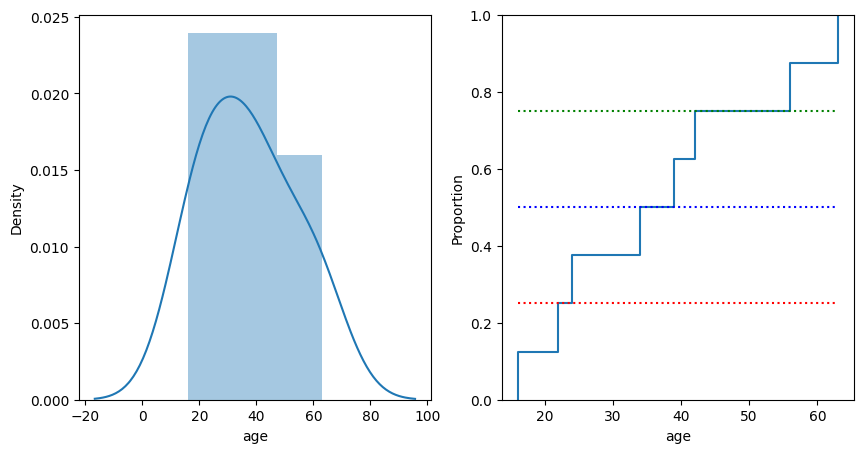

In [22]:
fig , (ax1,ax2) = plt.subplots(1,2, figsize=  (10,5))

sns.distplot(users_df.age , ax = ax1)
sns.ecdfplot(users_df.age, ax = ax2)
ax2.plot([users_df.age.min(),users_df.age.max()],[0.25,0.25], "r:" ,label = "0.25")
ax2.plot([users_df.age.min(),users_df.age.max()],[0.5,0.5], "b:", label = "0.5")
ax2.plot([users_df.age.min(),users_df.age.max()],[0.75,0.75], "g:" , label = "0.75")

In [23]:
ages_df = pd.get_dummies(users_df.user_age_group)

ages_df.columns = ["19세 이하","20대", "30대", "40대", "50대", "60대 이상"]
ages_df

,19세 이하,20대,30대,40대,50대,60대 이상
0,False,False,False,False,False,True
1,True,False,False,False,False,False
2,False,False,False,True,False,False
3,False,True,False,False,False,False
4,False,False,True,False,False,False
5,False,False,True,False,False,False
6,False,True,False,False,False,False
7,False,False,False,False,True,False


In [24]:
users_df = pd.concat([users_df, ages_df], axis=1)

users_df.drop("user_age_group", axis=1, inplace=True)
users_df.drop("age", axis=1, inplace=True)
users_df

,user_id,user_mbti,gender_0,gender_1,19세 이하,20대,30대,40대,50대,60대 이상
0,0ff9b159-2de4-11ef-9ffb-7085c2d2eea0,INFP,True,False,False,False,False,False,False,True
1,30ee77a1-2de5-11ef-9ffb-7085c2d2eea0,ENTP,True,False,True,False,False,False,False,False
2,7786d5d6-2de5-11ef-9ffb-7085c2d2eea0,ISFJ,True,False,False,False,False,True,False,False
3,ace0a147-2de2-11ef-9ffb-7085c2d2eea0,ISTJ,False,True,False,True,False,False,False,False
4,b89ea7fe-2de2-11ef-9ffb-7085c2d2eea0,INFP,False,True,False,False,True,False,False,False
5,c7686adc-2de2-11ef-9ffb-7085c2d2eea0,ESTJ,False,True,False,False,True,False,False,False
6,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,ENFP,True,False,False,True,False,False,False,False
7,f4bab5b7-2de3-11ef-9ffb-7085c2d2eea0,INTP,True,False,False,False,False,False,True,False


##### field : MBTI

In [25]:
mbti_df = pd.get_dummies(users_df.user_mbti)
mbti_df

,ENFP,ENTP,ESTJ,INFP,INTP,ISFJ,ISTJ
0,False,False,False,True,False,False,False
1,False,True,False,False,False,False,False
2,False,False,False,False,False,True,False
3,False,False,False,False,False,False,True
4,False,False,False,True,False,False,False
5,False,False,True,False,False,False,False
6,True,False,False,False,False,False,False
7,False,False,False,False,True,False,False


In [26]:
users_df = pd.concat([users_df,mbti_df], axis=1)
users_df.drop("user_mbti",axis=1, inplace=True)
users_df

,user_id,gender_0,gender_1,19세 이하,20대,30대,40대,50대,60대 이상,ENFP,ENTP,ESTJ,INFP,INTP,ISFJ,ISTJ
0,0ff9b159-2de4-11ef-9ffb-7085c2d2eea0,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False
1,30ee77a1-2de5-11ef-9ffb-7085c2d2eea0,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False
2,7786d5d6-2de5-11ef-9ffb-7085c2d2eea0,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
3,ace0a147-2de2-11ef-9ffb-7085c2d2eea0,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True
4,b89ea7fe-2de2-11ef-9ffb-7085c2d2eea0,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False
5,c7686adc-2de2-11ef-9ffb-7085c2d2eea0,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False
6,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,True,False,False,True,False,False,False,False,True,False,False,False,False,False,False
7,f4bab5b7-2de3-11ef-9ffb-7085c2d2eea0,True,False,False,False,False,False,True,False,False,False,False,False,True,False,False


### concat X_fields

In [27]:
ratings_df.head()

,user_id,regioncd_value,pla_r_rate
0,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,4,5.8
1,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,4,7.4
2,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,2,6.6
3,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,2,8.5
4,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,1,7.6


In [28]:
travels_df.head()

,regioncd_value,100%당근주스,10월제주애플망고,10월축제,1100고지,1100고지습지,1~2시간,1박2일,1성급,1시간미만,...,힐링,힐링비누,힐링소풍,힐링숙소,힐링쉼터,힐링여행,힐링제주,힐링콘서트노고록이,﻿,﻿제주
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
users_df.head()

,user_id,gender_0,gender_1,19세 이하,20대,30대,40대,50대,60대 이상,ENFP,ENTP,ESTJ,INFP,INTP,ISFJ,ISTJ
0,0ff9b159-2de4-11ef-9ffb-7085c2d2eea0,True,False,False,False,False,False,False,True,False,False,False,True,False,False,False
1,30ee77a1-2de5-11ef-9ffb-7085c2d2eea0,True,False,True,False,False,False,False,False,False,True,False,False,False,False,False
2,7786d5d6-2de5-11ef-9ffb-7085c2d2eea0,True,False,False,False,False,True,False,False,False,False,False,False,False,True,False
3,ace0a147-2de2-11ef-9ffb-7085c2d2eea0,False,True,False,True,False,False,False,False,False,False,False,False,False,False,True
4,b89ea7fe-2de2-11ef-9ffb-7085c2d2eea0,False,True,False,False,True,False,False,False,False,False,False,True,False,False,False


In [30]:
ratings_df = ratings_df.merge(users_df, how="left")
ratings_df = ratings_df.merge(travels_df, how="left")
ratings_df

,user_id,regioncd_value,pla_r_rate,gender_0,gender_1,19세 이하,20대,30대,40대,50대,...,힐링,힐링비누,힐링소풍,힐링숙소,힐링쉼터,힐링여행,힐링제주,힐링콘서트노고록이,﻿,﻿제주
0,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,4,5.8,True,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0
1,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,4,5.8,True,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0
2,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,4,5.8,True,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0
3,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,4,5.8,True,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0
4,d3ca4a15-2a0c-11ef-9ffb-7085c2d2eea0,4,5.8,True,False,False,True,False,False,False,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105295,b89ea7fe-2de2-11ef-9ffb-7085c2d2eea0,3,3.8,False,True,False,False,True,False,False,...,0,0,0,0,0,0,0,0,0,0
105296,b89ea7fe-2de2-11ef-9ffb-7085c2d2eea0,3,3.8,False,True,False,False,True,False,False,...,0,0,0,0,0,0,0,0,0,0
105297,b89ea7fe-2de2-11ef-9ffb-7085c2d2eea0,3,3.8,False,True,False,False,True,False,False,...,0,0,0,0,0,0,0,0,0,0
105298,b89ea7fe-2de2-11ef-9ffb-7085c2d2eea0,3,3.8,False,True,False,False,True,False,False,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# target
target = ratings_df["pla_r_rate"]
ratings_df.drop("pla_r_rate", inplace=True, axis=1)

In [32]:
binary_target = target>= 4.0

## baseline : BinaryClassifier with normal DNN

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
train_x, test_x, train_y, test_y = train_test_split(ratings_df, binary_target)

In [35]:
model = keras.models.Sequential([
    keras.layers.Dense(400,activation="relu"),
    keras.layers.Dense(400,activation="relu"),
    keras.layers.Dense(400,activation="relu"),
    keras.layers.Dense(1,activation = "sigmoid"),
])

In [1]:
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer = keras.optimizers.Adam(0.001),
              metrics=[
                  keras.metrics.AUC(),
                  keras.metrics.BinaryAccuracy()
              ])

NameError: name 'model' is not defined

In [ ]:
history = model.fit(train_x, train_y, epochs=5, batch_size=32,
                    validation_data=(test_x, test_y))